# References and resources
* Folium plugins : https://python-visualization.github.io/folium/plugins.html
* Blog : https://oceanservice.noaa.gov/hazards/marinedebris/plastics-in-the-ocean.html
* **Notebook : [ https://www.kaggle.com/brsdincer/marine-micro-plastic-analysis-process/notebook ]**

# About Microplastics
**The problem with plastic**

While it’s tough to say exactly how much plastic is in the ocean, scientists think about 8 million metric tons of plastic entered the ocean in 2010. That’s the weight of nearly 90 aircraft carriers, and the problem continues to grow.

These plastics come in many different forms. Just think about all the plastic items you use daily: the toothbrush you grab first thing in the morning, the container your lunch comes in, or the bottle you drink water from after your workout.

All these things get used and, eventually, thrown out. Many plastic products are single-use items that are designed to be thrown out, like water bottles or take out containers. These are used and discarded quickly. If this waste isn’t properly disposed of or managed, it can end up in the ocean.

Unlike some other kinds of waste, plastic doesn’t decompose. That means plastic can stick around indefinitely, wreaking havoc on marine ecosystems. Some plastics float once they enter the ocean, though not all do. As the plastic is tossed around, much of it breaks into tiny pieces, called microplastics.

**src**: https://oceanservice.noaa.gov/hazards/marinedebris/plastics-in-the-ocean.html

!['Marine Plastic'](https://aambpublicoceanservice.blob.core.windows.net/oceanserviceprod/hazards/marinedebris/plastics_in_the_ocean_lesstext.jpg)

In [1]:
%autosave 300
# %autoreload 100

Autosaving every 300 seconds


In [15]:
#general
import os
import numpy as np
import pandas as pd 

#plotting 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

#mapping
import geopandas as gpd 
import folium
from folium.plugins import MarkerCluster,HeatMap,HeatMapWithTime
import branca.colormap as colormap
from collections import defaultdict



# Loading data 

# Data 
What is the project and why is it important?

    Microplastics are plastic debris pieces that are smaller than five millimeters in size. They can be found in most habitats on Earth as well as in the digestive tracts of many marine organisms and sea birds. As more research is done on this type of debris, the need for global standardization of sampling methods has been recognized. Since there is no single agreed-upon method for counting and weighing microplastics in water samples, it is difficult to compare results across studies. Although common approaches may be used, most laboratories develop their own procedures for microplastic sampling and processing based on factors such as budget, equipment availability, labor, and the specific research questions being asked. “Interlaboratory comparisons” are performed in many scientific fields, during which multiple labs are asked to analyze identical samples in order to test their ability to produce reliable and repeatable measurements; this can be a step toward the development of standardized sampling methods.

    This project was composed of two parts aimed to address the standardization of microplastic sampling protocols. First, a standardized laboratory protocol was developed for isolating and quantifying microplastic debris in environmental samples. Second, an interlaboratory comparison was conducted to evaluate if protocols used by various labs for quantifying microplastics in water samples were comparable.

    For the first stage of the project, researchers from the University of Washington Tacoma created a simple, cost-effective, and unbiased laboratory method to quantify microplastic debris in environmental samples. The protocol focuses on the filtration, separation, and quantification of many common microplastics. The protocol varies slightly depending on whether the sample is beach sand, bed sediment, or water, but the general procedure includes an initial sieving/separation of the sample, the removal of organic matter, a second separation, and finally drying, sorting, and weighing the sample. For more, access the full laboratory protocol.

    The interlaboratory comparison was the second part of this project and to our knowledge, is the first study to compare different laboratory protocols for isolating and quantifying microplastic debris in water samples. To start, reference samples were created by adding known amounts of microplastic particles and organic matter to filtered water. These samples were then mailed to six national and international research laboratories well-versed in microplastic research. These laboratories used their own protocols to filter, isolate, and quantify the microplastic debris. Researchers reported their results to the team at the University of Washington Tacoma and comparisons were made between the known microplastic values from the reference samples and the values reported from each of the laboratories.

src: https://www.kaggle.com/brsdincer/marine-microplastic-on-world-density-noaa

In [29]:
adv_sci = gpd.read_file('../input/marine-microplastic-on-world-density-noaa/MICROPLASTIC_DATA_BASED_ON_LAT_LONG/ADVENTURE_MICRO_FROM_SCIENTIST.csv',)
geomar = gpd.read_file('../input/marine-microplastic-on-world-density-noaa/MICROPLASTIC_DATA_BASED_ON_LAT_LONG/GEOMARINE_MICRO.csv')
sea_micro = gpd.read_file('../input/marine-microplastic-on-world-density-noaa/MICROPLASTIC_DATA_BASED_ON_LAT_LONG/SEA_MICRO.csv')

In [30]:
#create a geom obj
def get_geom(df,adn):
    '''get a geometry variable'''
    df[['Latitude','Longitude']]=df[['Latitude','Longitude']].astype(dtype=float)
    df[adn] = df[adn].astype(dtype=float)
#     df[['Latitude','Longitude']]=df[['Latitude','Longitude']].astype('float16')
    df['Geometry'] = pd.Series([(df.loc[i,'Latitude'],df.loc[i,'Longitude']) for i in range(len(df['Latitude']))])
    
def to_datetime(df,date_col='Date',frmt='%Y-%m-%d'):
    '''add_date col as datetime'''
    df[date_col] =pd.to_datetime(df[date_col],errors='coerce')
    df['year'] = df[date_col].dt.year
    
#get geometry
get_geom(adv_sci,'Total_Pieces_L')
get_geom(geomar,'MP_conc__particles_cubic_metre_')
get_geom(sea_micro,'Pieces_KM2')

#set to datetime'
to_datetime(adv_sci)
to_datetime(geomar)
to_datetime(sea_micro)

# Exploratory Data Analysis

**Helper code**

In [58]:
def plot_hist(arr,
              label,
              ax1=None,
              n_bins=30):
    
    if not ax1:
        ax1=plt.figure(figsize=(12,6))
        
    plt.hist(arr,bins=n_bins)
    plt.title(f'Histogram {label}')
    plt.ylabel('Count')
    plt.xlabel(f'{label}')
    
    
def plot_yearly_average(df,
                        col,
                        title):
    ax1=plt.figure(figsize=(14,7))
    
    df1= df.copy()
    
    gb = df1.groupby('year').agg({col:['mean','median']}).droplevel(level=0,axis=1)
    gb.reset_index(inplace=True)
        
    plt.plot(gb['year'],gb['mean'],color='b',label=f'mean {col}')
    plt.plot(gb['year'],gb['median'],color='g',label=f'median {col}')
    
    plt.xlabel('Year')
    plt.ylabel(f'{title}')
    plt.title(f'Yearly Average {title}')
    plt.legend()
    plt.show()

# Adventure Scientist data 

In [32]:
#set style for visualization
plt.style.use('seaborn-white')

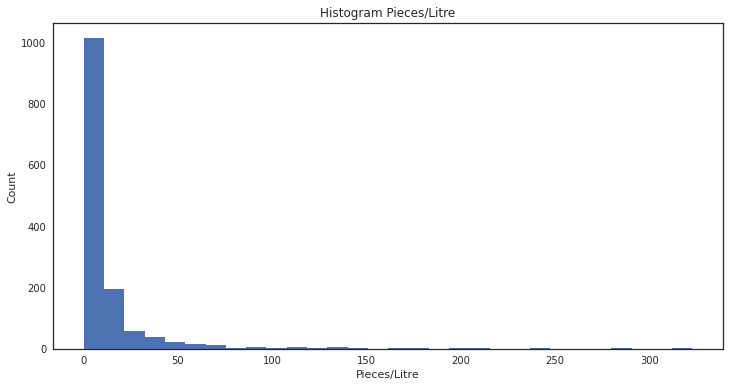

In [33]:
#distribution of data
plot_hist(arr=adv_sci['Total_Pieces_L'],
         label='Pieces/Litre',
         n_bins=30)

In [34]:
#find loc with most dense

max_plas = adv_sci['Total_Pieces_L'].max()
idx= adv_sci[adv_sci['Total_Pieces_L']==max_plas].index
date1=str(adv_sci.loc[idx,'Date'].values).split('T')[0].split('[')[1]
loc1= adv_sci.iloc[idx][['Latitude','Longitude']].values

print('Maximum plastic found per Litre is {} on date {} at {}'.format(max_plas,date1,loc1))


Maximum plastic found per Litre is 323.0 on date '2015-11-12 at [[ 34.2     -77.26667]]


In [62]:
#plotting area of study 
start_loc= (np.mean(adv_sci['Latitude']),np.mean(adv_sci['Longitude']))

#map
m_1=folium.Map(location=start_loc,
              tiles='Open Street Map',
              zoom_start=2,
              min_zoom=1.5)

#heatmap:
HeatMap(data=adv_sci[['Latitude','Longitude','Total_Pieces_L']].values,
        radius=10,
        blur=5).add_to(m_1)

#add area of highest concentration
folium.CircleMarker(location= (loc1[0][0],loc1[0][1]),
                  tooltip="<b>max plastic density</b>",
                  color='black',
                  radius=15).add_to(m_1)


print('Study area Heatmap (Adventure Scientist) ')
m_1

Study area Heatmap (Adventure Scientist) 


# **Yearly TimeSeries of the Adventure Sci data**

In [83]:
m_2=folium.Map(location=start_loc,
              tiles='Open Street Map',
              zoom_start=2,
              min_zoom=1.5)



d1= defaultdict(list)

for row in adv_sci.itertuples():
    d1[row.Date.month].append([row.Latitude,row.Longitude,row.Total_Pieces_L])

h1=HeatMapWithTime(data=list(d1.values()),
                index=list(d1.keys()),
                radius=10,
                min_opacity=0.1,
                max_opacity=0.6,
                auto_play=True).add_to(m_2)

print('Month by month Visualization of Adv Sci Data')

m_2

Month by month Visualization of Adv Sci Data


# GeoMarine Data 

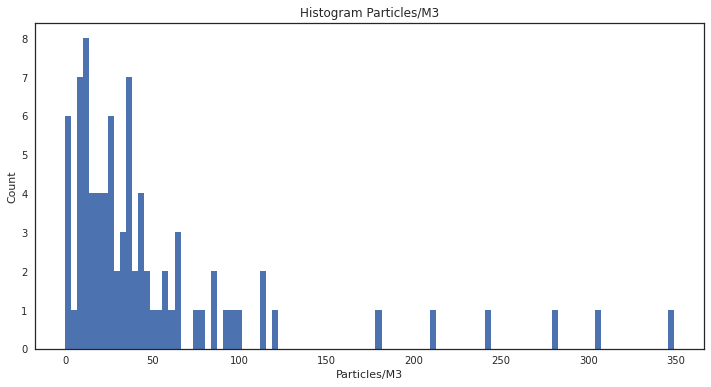

In [64]:
#distribution of data
plot_hist(arr=geomar['MP_conc__particles_cubic_metre_'],
         label='Particles/M3',
         n_bins=100)

In [66]:
# geomar['Datto_listd.to_datetime(geomar['Date'],errors='coerce')

mas_plas = geomar['MP_conc__particles_cubic_metre_'].max()
loc2=geomar[geomar['MP_conc__particles_cubic_metre_']==mas_plas][['Latitude','Longitude']].values

print('Maximum micro plastic concentration found per Cubic Meter is {} at {}'.format(max_plas,
                                                                     loc2))


Maximum micro plastic concentration found per Cubic Meter is 323.0 at [[ 21.50771174 119.5476918 ]]


In [67]:
#plotting area of study 
start_loc= (geomar['Latitude'].mean(),geomar['Longitude'].mean())

#map
m_3=folium.Map(location=start_loc,
              tiles='Open Street Map',
              zoom_start=2,
              min_zoom=1.5)

#heatmap:
HeatMap(data=geomar[['Latitude','Longitude','MP_conc__particles_cubic_metre_']],
        radius=10,
        blur=5,
        opacity=.1).add_to(m_3)

#add area of highest concentration
folium.CircleMarker(location= (loc2[0][0],loc2[0][1]),
                  tooltip="<b>max plastic density</b>",
                  color='black',
                  radius=15).add_to(m_3)


print('Study area Heatmap (GeoMarine) ')
m_3

Study area Heatmap (GeoMarine) 


# TimeSeries Visualization of Geomar Data.

In [84]:
m_4=folium.Map(location=start_loc,
              tiles='Open Street Map',
              zoom_start=2,
              min_zoom=1.5)



d2= defaultdict(list)

for row in geomar.itertuples():
    d2[row.Date.month].append([row.Latitude,row.Longitude,row.MP_conc__particles_cubic_metre_])

h2=HeatMapWithTime(data=list(d2.values()),
                index=list(d2.keys()),
                radius=10,
                min_opacity=0.1,
                max_opacity=0.6,
                auto_play=True,
               control=True,
                show=True).add_to(m_4)


print('Monthwise time series visualization of geomar data')

m_4

Monthwise time series visualization of geomar data


# SEA data

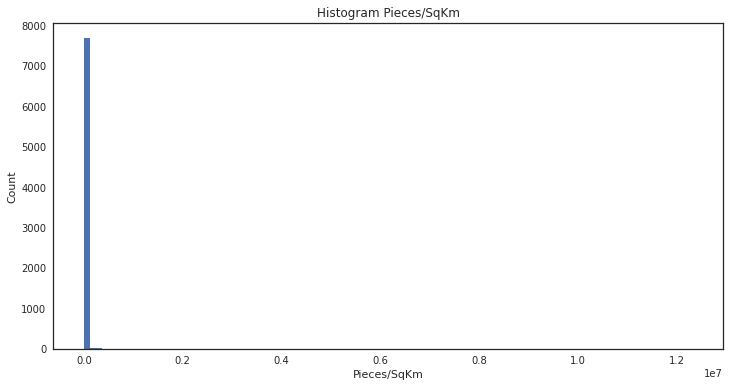

In [85]:
#distribution of data 
plot_hist(arr=sea_micro['Pieces_KM2'],
         label='Pieces/SqKm',
         n_bins=100)

In [86]:
#find max pollution reion


mas_plas = sea_micro['Pieces_KM2'].max()
loc3=sea_micro[sea_micro['Pieces_KM2']==mas_plas][['Latitude','Longitude']].values

print('Maximum micro plastic concentration found per Cubic Meter is {} at {}'.format(max_plas,
                                                                     loc3))

Maximum micro plastic concentration found per Cubic Meter is 323.0 at [[  28.72 -140.03]]


In [89]:
#plotting area of study 
start_loc= (sea_micro['Latitude'].mean(),sea_micro['Longitude'].mean())

#map
m_5=folium.Map(location=start_loc,
              tiles='Open Street Map',
              zoom_start=2,
              min_zoom=1.5)

#heatmap:
HeatMap(data=sea_micro[['Latitude','Longitude','Pieces_KM2']],
        radius=10,
        blur=5,
        opacity=.1).add_to(m_5)

#add area of highest concentration
folium.CircleMarker(location= (loc3[0][0],loc3[0][1]),
                  tooltip="<b>max plastic density</b>",
                  color='black',
                  radius=15).add_to(m_5)


print('Study area Heatmap (SeaMicro) ')
m_5

Study area Heatmap (SeaMicro) 


# Visualizing sea_micro TimeSeries

In [93]:
m_6=folium.Map(location=start_loc,
              tiles='Open Street Map',
              zoom_start=2,
              min_zoom=1.5)



d3= defaultdict(list)

for row in sea_micro.itertuples():
    d3[row.Date.month].append([row.Latitude,row.Longitude,row.Pieces_KM2])

h3=HeatMapWithTime(data=list(d2.values()),
                index=list(d2.keys()),
                radius=10,
                min_opacity=0.1,
                max_opacity=0.6,
                auto_play=True,
               control=True,
                show=True).add_to(m_6)


print('Monthwise time series visualization of Sea_Micro data')

m_6

Monthwise time series visualization of Sea_Micro data


**The data from studies show that there is micro-plastic present in high concentration in our oceans, even in the remotest regions of the ocean.**

**END**